In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet

start_date = '2019-01-01'
end_date = '2022-01-01'

dates = pd.date_range(start=start_date, end=end_date, freq='D')
unix_dates = np.array([int(pd.Timestamp(d).timestamp()) for d in dates])
# Recreate a DatetimeIndex with a specific frequency

freq = 'D'  # Monthly frequency
date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

prices = np.sin(unix_dates)

data = pd.DataFrame({'ds': date_rng, 'y': prices})

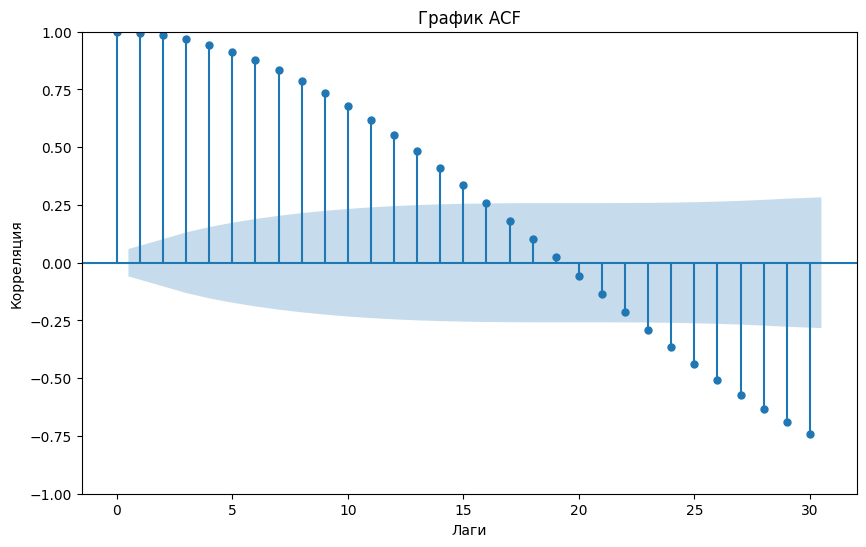

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


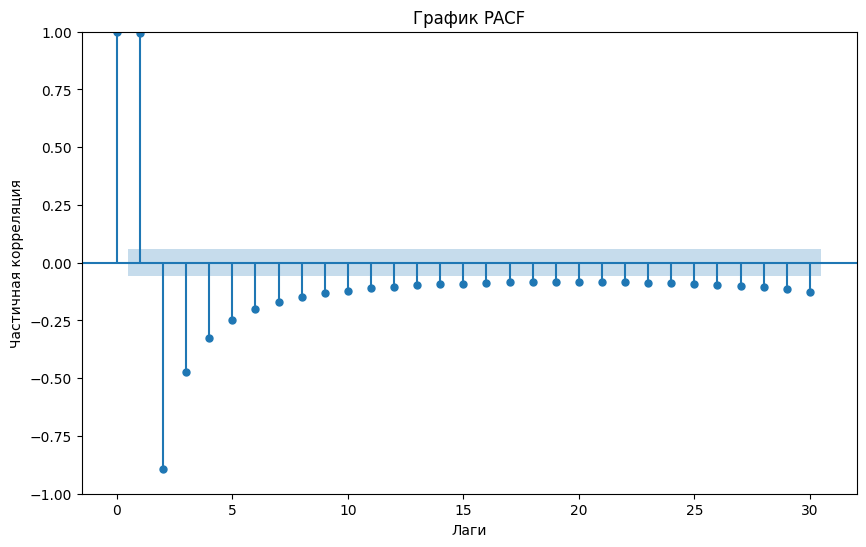

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
# Построение графика автокорреляционной функции (ACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.title('График ACF')
plt.show()
# Построение графика частичной автокорреляционной функции (PACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Частичная корреляция')
plt.title('График PACF')
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6590239738327134e+16
p-value: 0.0


In [5]:
train_size = int(len(prices) * 0.7)
test_size = len(prices) - train_size

In [6]:
model_data = pd.DataFrame({'Price': prices[0:train_size], 'Date': date_rng[1:train_size + 1]})
model_data = model_data.set_index('Date', inplace = False)
model_data.head(10)

,Price
Date,
2019-01-02,-0.885371
2019-01-03,-0.920145
2019-01-04,-0.948861
2019-01-05,-0.971331
2019-01-06,-0.987407
2019-01-07,-0.996982
2019-01-08,-0.999994
2019-01-09,-0.996423
2019-01-10,-0.986292


In [7]:
from statsmodels.tsa.ar_model import AutoReg

# Поиск оптимального числа лагов с использованием AIC
max_lags = 20  # Максимальное количество лагов для рассмотрения
aic_values = []

for lag in range(1, max_lags+1):
    model = AutoReg(model_data, lags=lag)
    results = model.fit()
    aic_values.append(results.aic)

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWar

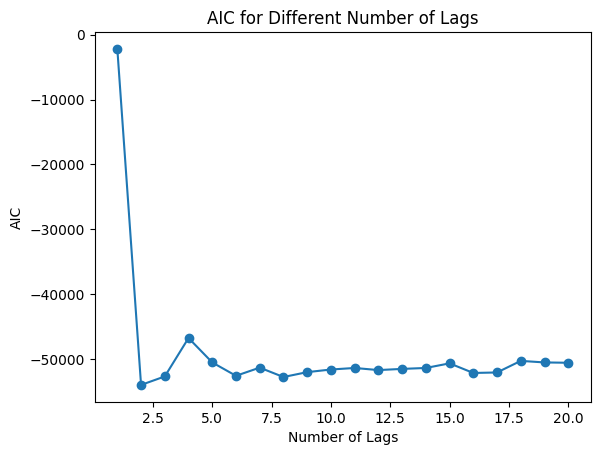

In [8]:
# Визуализация значений AIC для разных количеств лагов
plt.plot(range(1, max_lags+1), aic_values, marker='o')
plt.xlabel('Number of Lags')
plt.ylabel('AIC')
plt.title('AIC for Different Number of Lags')
plt.show()

In [9]:
# Выбор оптимального числа лагов на основе минимального значения AIC
optimal_lag = np.argmin(aic_values) + 1
print(f"Optimal number of lags: {optimal_lag}")

Optimal number of lags: 2


In [11]:
# Обучение модели с оптимальным числом лагов
optimal_model = AutoReg(model_data, lags = optimal_lag)
optimal_results = optimal_model.fit()

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
# Прогнозирование на тестовом наборе данных
predictions = optimal_results.predict(start = len(model_data), end = len(prices)-1)
predictions

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2021-02-07   -0.483292
2021-02-08   -0.552675
2021-02-09   -0.618419
2021-02-10   -0.680092
2021-02-11   -0.737288
                ...   
2021-12-29   -0.984278
2021-12-30   -0.966719
2021-12-31   -0.942796
2022-01-01   -0.912667
2022-01-02   -0.876529
Freq: D, Length: 330, dtype: float64

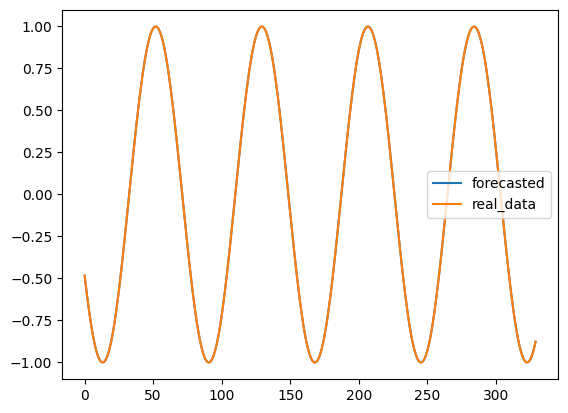

In [15]:
plt.plot(predictions.values, label = "forecasted")
plt.plot(prices[train_size:], label = "real_data")
plt.legend()

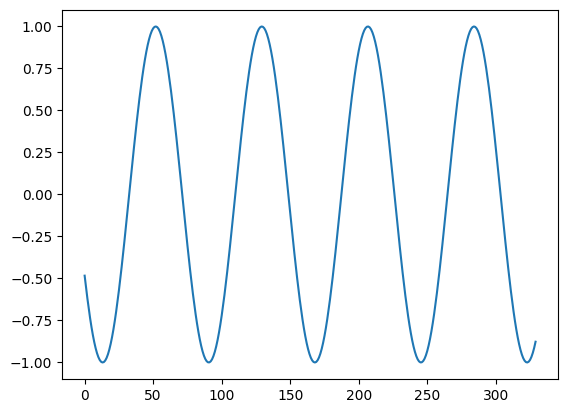

In [16]:
plt.plot(predictions.values, label = "forecasted")

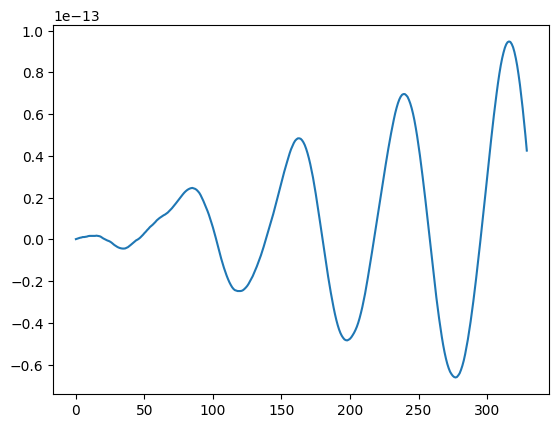

In [17]:
plt.plot(predictions.values - prices[train_size:], label = "")